<a href="https://colab.research.google.com/github/gvalencios/demoNeuralNetwork/blob/main/Character_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Mounting gdrive to open and store file*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Initialization process**

In [ ]:
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json

from pathlib import Path

images_folder_path = Path('/content/drive/MyDrive/HKUUAS/suas-odcl-training-assets-master/output')
image_paths = list(images_folder_path.glob("*.png"))
image_path= image_paths[0]

image_path

PosixPath('/content/drive/MyDrive/HKUUAS/suas-odcl-training-assets-master/output/8b0cafea-1aea-45eb-a4c5-e5c48aca81ef.png')

In [ ]:
json_path = image_path.parent / (image_path.stem + ".json")
with open(json_path, "r") as f:
  data = json.loads(f.read())

json_path

PosixPath('/content/drive/MyDrive/HKUUAS/suas-odcl-training-assets-master/output/8b0cafea-1aea-45eb-a4c5-e5c48aca81ef.json')

**Cropping**

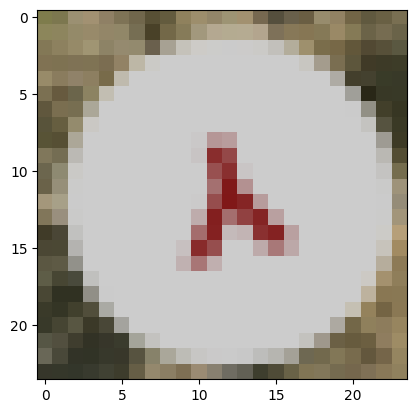

In [ ]:
#crop the image
import os
img = Image.open(image_path)
cropped_img = img.crop(data['bbox'])

plt.imshow(cropped_img)

**Add filter to the image**

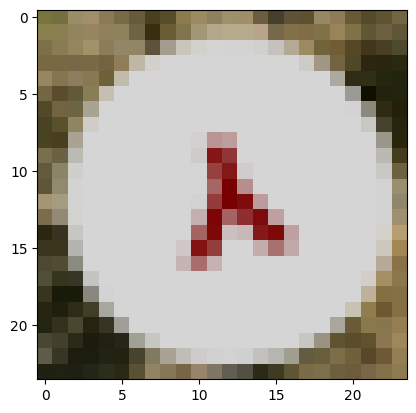

In [ ]:
#image brightness enhancer
enhancer = ImageEnhance.Contrast(cropped_img)

factor = 1.2
cropped_img_enhanced = enhancer.enhance(factor)

plt.imshow(cropped_img_enhanced)

**Edge detection**

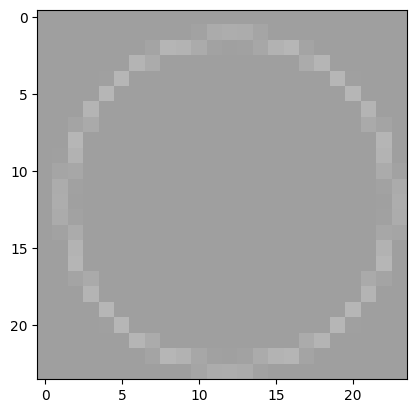

In [ ]:
#detect edge
filter = ImageEnhance.Contrast(cropped_img_enhanced)
bw = (filter.enhance(0))

plt.imshow(bw)

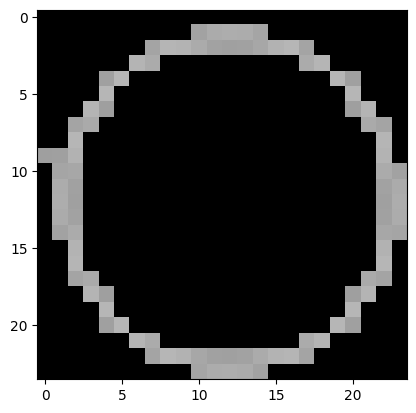

In [ ]:
#sharpening the image
bw_blackenned = bw.copy()
pixels = bw_blackenned.load() # create the pixel map

for i in range(bw.size[0]): # for every pixel:
     for j in range(bw.size[1]):
        if pixels[i,j][3] == 255:
             pixels[i, j] = (0, 0, 0, 255)

plt.imshow(bw_blackenned)

**FILL CONTOUR of the edge so that we can change the background to white**

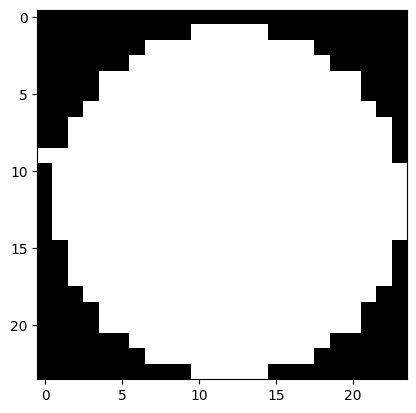

In [ ]:
# Read image as grayscale
_im = np.copy(bw_blackenned)
img = cv2.cvtColor(_im, cv2.COLOR_BGR2GRAY)
hh, ww = img.shape[:2]

# threshold
thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)[1]

# get the (largest) contour
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)

# draw white filled contour on black background
result = np.zeros_like(img)
cv2.drawContours(result, [big_contour], 0, (255,255,255), cv2.FILLED)
filled_shape = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.imshow(filled_shape)

**produce final image (that only show the shape and text)**

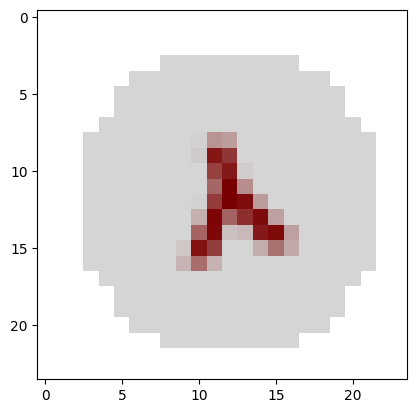

In [ ]:
#change background color into shape colour
image = np.copy(cropped_img_enhanced)
for i in range(24):
  for j in range(24):
    if np.array_equal(filled_shape[i][j], np.array([0, 0, 0])) == True:
      image[i][j] = [255, 255, 255, 255]
    if np.array_equal(np.copy(bw_blackenned)[i][j], np.array([0, 0, 0, 255])) == False:
      image[i][j] = [255, 255, 255, 255]

plt.imshow(image)

**GENERATE FINAL SHAPE**

turn everything other than background into black

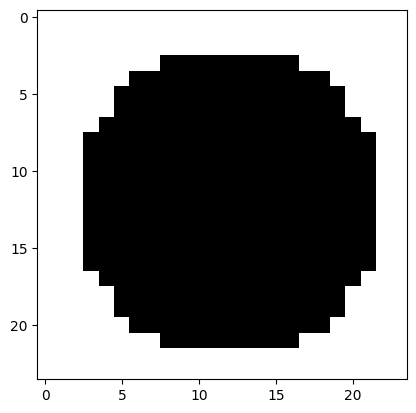

In [ ]:
finalSHAPE = np.copy(image)
for i in range(24):
  for j in range(24):
    if np.array_equal(finalSHAPE[i][j], np.array([255, 255, 255, 255])) == False:
      finalSHAPE[i][j] = [0, 0, 0, 255]

plt.imshow(finalSHAPE)

**GENERATE FINAL CHARACTER**

know the shape colour

In [ ]:
#to know the shape color
r, g, b, count = 0, 0, 0, 0
for i in range(24):
  for j in range(24):    
    if np.array_equal(image[i][j], np.array([255,255,255,255])) == False:
      count += 1
      r += image[i][j][0]
      g += image[i][j][1] 
      b += image[i][j][2] 
      break
r, g, b = r/count, g/count, b/count
shape_colour = [r,g,b,255]
shape_colour

[213.0, 213.0, 213.0, 255]

turn the background into shape colour

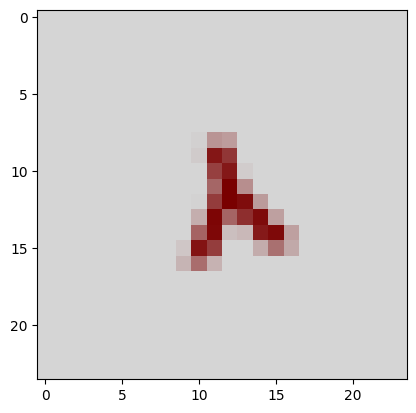

In [ ]:
textV1 = np.copy(image)
for i in range(24):
  for j in range(24):
    if np.array_equal(textV1[i][j], np.array([255, 255, 255, 255])) == True:
      textV1[i][j] = np.copy(shape_colour)

plt.imshow(textV1)

use k-means clustering to focus on the text colour

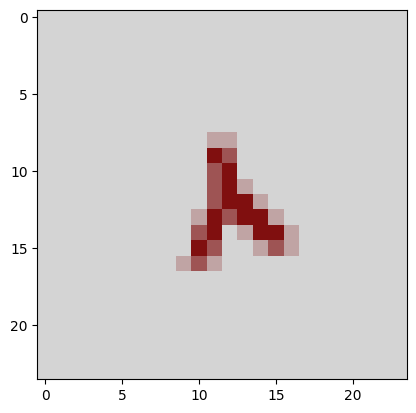

In [ ]:
# Reshaping the image into a 2D array of pixels and 3 color values (RGB)
_pixel = cv2.cvtColor(textV1, cv2.COLOR_RGB2BGR)
pixel_vals = _pixel.reshape((-1,3))

# Convert to float type
pixel_vals = np.float32(pixel_vals)

#the below line of code defines the criteria for the algorithm to stop running,
#which will happen is 100 iterations are run or the epsilon (which is the required accuracy)
#becomes 85%
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

# then perform k-means clustering with number of clusters defined as 3
#also random centres are initially choosed for k-means clustering
k = 4
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((_pixel.shape))
segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

plt.imshow(segmented_image)

Add black and white filter

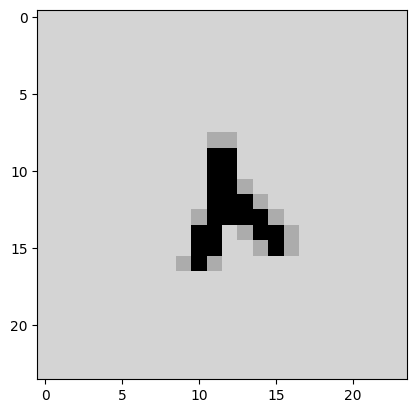

In [ ]:
#filter process
_imgray = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)
(thresh, im_bw) = cv2.threshold(_imgray, 127, 255, cv2.THRESH_TOZERO | cv2.THRESH_OTSU)
im_bw = cv2.cvtColor(im_bw, cv2.COLOR_GRAY2RGB)

plt.imshow(im_bw)

turn background to white

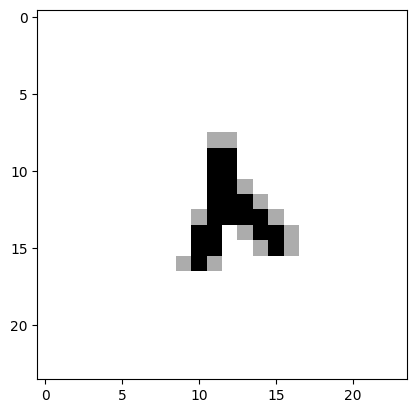

In [ ]:
textFINAL = np.copy(im_bw)
bg_colour = np.copy(textFINAL[0][0])
for i in range(24):
  for j in range(24):
    if np.array_equal(textFINAL[i][j], bg_colour) == True:
      textFINAL[i][j] = np.copy([255])

plt.imshow(textFINAL)

**DONE UNTIL HERE**